In [1]:
import torch as torch

In [2]:
if torch.cuda.is_available():
    cuda_id = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(cuda_id)
    device = "cuda:0"
else:
    device = "cpu"

### Download and preparethe data

We'll use the CIFAR10 dataset

In [3]:
import os
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [4]:
# download and augment the training dataset
if not os.path.exists("./data"):
    os.mkdir("./data")

data = CIFAR10(
    root="./data",
    train=True,
    transform=transforms.Compose(
        [
            transforms.RandomHorizontalFlip(),
            transforms.RandomResizedCrop(size=32, ratio=(0.9, 1.1)),
            transforms.ToTensor(),
            transforms.Normalize(0, 1),
        ]
    ),
    download=True,
)

data_loader = DataLoader(data, batch_size=16, shuffle=True)

Files already downloaded and verified


### Print out an example image

In [5]:
import matplotlib.pyplot as plt

In [6]:
def display(image, size=8):
    print(image[0].shape)
    image = image[0].permute((1, 2, 0))
    plt.figure(figsize=(size, size))
    plt.axis("off")
    plt.imshow(image)
    plt.show()

torch.Size([3, 32, 32])


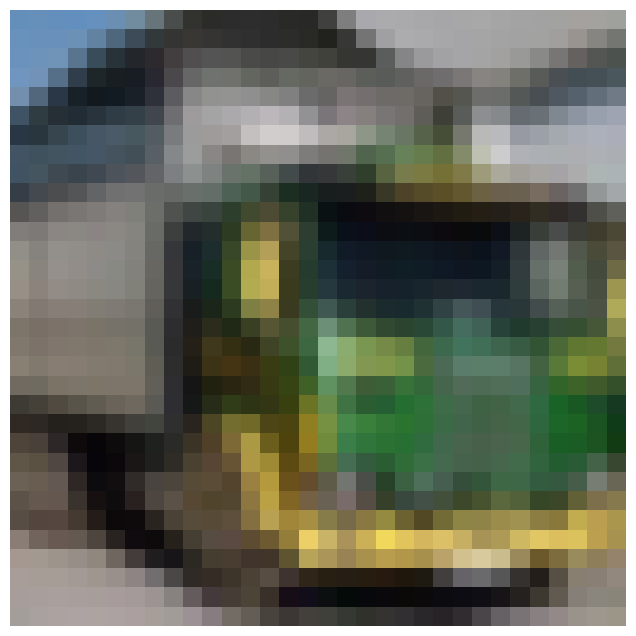

In [7]:
display(data[14])

### Split a batch of data into batch of patches

In [8]:
import torchvision.utils as vutils

In [9]:
def batch_patch(tensor, step=4):
    if len(tensor.shape) == 3:
        return (
            tensor.unfold(0, 3, 3)
            .unfold(1, step, step)
            .unfold(2, step, step)
            .flatten(start_dim=0, end_dim=2)
        )
    return (
        tensor.unfold(1, 3, 3)
        .unfold(2, step, step)
        .unfold(3, step, step)
        .squeeze()
        .flatten(start_dim=1, end_dim=2)
    )

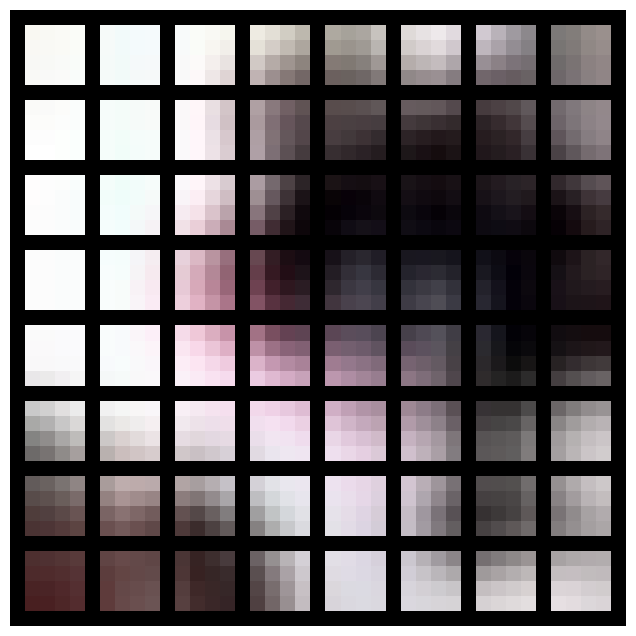

In [10]:
d = next(iter(data_loader))[0]

step = 4
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(
    (
        vutils.make_grid(
            batch_patch(d, step)[0], nrow=32 // step, padding=1, normalize=True
        )
        .permute(1, 2, 0)
        .detach()
        .cpu()
        .numpy()
    )
)

### Implement the model

In [11]:
import torch.nn as nn

First implement the learnable positional encoding layer - it was used in DDPM lab

In [32]:
class PositionalEncoding(nn.Module):
    def __init__(self, d=25, n=10000, output_size=256):
        super(PositionalEncoding, self).__init__()
        self.d = d
        self.denominator = torch.pow(n, torch.arange(d) / d)
        self.network = nn.Sequential(
            nn.Linear(2 * d, out_features=output_size),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=output_size, out_features=output_size),
        )

    def forward(self, k):
        input = torch.concat(
            [torch.sin(k / self.denominator), torch.cos(k / self.denominator)]
        ,1).to(device)
        return self.network(input)

Implement a transformer block - We'll need a few of them so it's easier to make a separate class

In [33]:
class TransformerBlock(nn.Module):
    def __init__(self, n_dims=256, n_heads=8):
        super(TransformerBlock, self).__init__()
        self.norm = nn.LayerNorm(n_dims)
        self.multihead_attention = nn.MultiheadAttention(n_dims, n_heads)
        self.network = nn.Sequential(
            nn.LayerNorm(n_dims),
            nn.Linear(n_dims, 2 * n_dims),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(2 * n_dims, n_dims),
            nn.Dropout(0.2),
        )

    def forward(self, input):
        post_norm = self.norm(input)
        post_attention = (
            self.multihead_attention(post_norm, post_norm, post_norm)[0] + input
        )
        return self.network(post_attention) + post_attention

Whole model

In [34]:
class VisionTransformerModel(nn.Module):
    def __init__(self, n_classes, patch_size=4,im_size=32, n_transformers=6, n_dims=256):
        super(VisionTransformerModel, self).__init__()
        self.patch_size = patch_size
        self.positional_embedding_keys = torch.arange((im_size//patch_size)**2+1).reshape(-1,1)
        self.patch_flatten = nn.Flatten(start_dim=-3)
        self.embed = nn.Linear(3 * patch_size**2, n_dims)
        self.positional_encode = PositionalEncoding(output_size=n_dims)
        self.dropout1 = nn.Dropout(0.2)
        self.transformers = [
            TransformerBlock(n_dims=n_dims) for _ in range(n_transformers)
        ]
        self.normalization = nn.LayerNorm(n_dims)
        self.flatten = nn.Flatten()
        self.MLP = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*64, 2 * n_dims),
            nn.ReLU(inplace=True),
            nn.Linear(2 * n_dims, 2 * n_dims),
            nn.ReLU(inplace=True),
            nn.Linear(2 * n_dims, n_classes),
            nn.Softmax(),
        )

    def forward(self, img):
        patched = batch_patch(img, self.patch_size)
        flattened = self.patch_flatten(patched)
        new_shape = list(flattened.shape)
        new_shape[-2]=1
        class_token = torch.rand(new_shape).to(device)              
        with_token = torch.concat([class_token,flattened],1)
        embedded = self.embed(with_token) + self.positional_encode(self.positional_embedding_keys)
        tr = self.dropout1(embedded)
        for transformer in self.transformers:
            tr = transformer(tr)
        normalized = self.normalization(tr)
        return self.MLP(normalized)

### Prepare the model for training

In [35]:
model = VisionTransformerModel(len(data.classes)).to(device)

In [36]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

In [37]:
for epoch in range(160):
    dis_cum_loss = 0
    gen_cum_loss = 0
    for batch in data_loader:
        batch_data = batch[0].to(device)
        batch_labels = batch[1]
        
        optimizer.zero_grad()
        pred = model(batch_data)
        loss = loss_fn(pred, batch_labels)
        
        loss.backward()
        optimizer.step()

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!